# Notebook Imports

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

# Pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator

%matplotlib inline

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

## Constants

In [3]:
FILE = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

# Step 1: Data Collection and Loading

* Large Movie Review Dataset [Link](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)

In [4]:
data = pd.read_csv(FILE)
df_full = pd.DataFrame(data)

df_full.drop([0], axis=0, inplace=True)
df_full.reset_index(drop=True, inplace=True)

df = df_full.sample(frac=0.3)
df.head()

,review,sentiment
35172,"SO good, the acting, cutting, directing in the...",positive
45440,"What a wonderful movie, eligible for so many l...",positive
29623,That song keeps humming in my head. Not the gr...,negative
44446,A female executioner (played by the sexy Jenni...,positive
21092,I watched this movie last night and already I ...,negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 35172 to 10634
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     15000 non-null  object
 1   sentiment  15000 non-null  object
dtypes: object(2)
memory usage: 351.6+ KB


In [6]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
review       0
sentiment    0
dtype: int64


In [7]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")


The shape of the data: (15000, 2)

The types of the data: 
review       object
sentiment    object
dtype: object



# Step 2: Data Preprocessing

* **Text Cleaning:** Remove any HTML tags, special characters, numbers, and other non-alphabetic characters.
* **Tokenization:** Split the reviews into individual words (tokens).
* **Stop Words Removal:** Remove common words that do not contribute to the sentiment, such as 'and', 'the', 'is', etc.
* **Lemmatization:** Reduce words to their base or root form.

### Text Cleaning

In [8]:
df.nunique()

review       14961
sentiment        2
dtype: int64

In [9]:
df = df.drop_duplicates()
print(df.shape)
df.head()

(14961, 2)


,review,sentiment
35172,"SO good, the acting, cutting, directing in the...",positive
45440,"What a wonderful movie, eligible for so many l...",positive
29623,That song keeps humming in my head. Not the gr...,negative
44446,A female executioner (played by the sexy Jenni...,positive
21092,I watched this movie last night and already I ...,negative


In [10]:
# remove html tags from text
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

### Tokenization, Stop Words Removal, Lemmatization

In [11]:
def clean_review(text, wl=WordNetLemmatizer(), 
               stop_words=set(stopwords.words('english'))):
    # Remove HTML tags
    cleaned_text = remove_html_tags(text)
    
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(wl.lemmatize(word))
    
    filtered_words = ' '.join(filtered_words)    
     
    return filtered_words

In [12]:
%%time
nested_list = df.review.apply(clean_review)
df['review'] = nested_list

CPU times: user 38.7 s, sys: 119 ms, total: 38.8 s
Wall time: 38.8 s


In [13]:
df.head()

,review,sentiment
35172,good acting cutting directing may best ever da...,positive
45440,wonderful movie eligible many label never get ...,positive
29623,song keep humming head greatest song movie lea...,negative
44446,female executioner played sexy jennifer thomas...,positive
21092,watched movie last night already struggling re...,negative


In [14]:
nested_list.head()

35172    good acting cutting directing may best ever da...
45440    wonderful movie eligible many label never get ...
29623    song keep humming head greatest song movie lea...
44446    female executioner played sexy jennifer thomas...
21092    watched movie last night already struggling re...
Name: review, dtype: object

In [15]:
label_encoder = LabelEncoder() 
df['category']= label_encoder.fit_transform(df['sentiment']) 

df.head()

,review,sentiment,category
35172,good acting cutting directing may best ever da...,positive,1
45440,wonderful movie eligible many label never get ...,positive,1
29623,song keep humming head greatest song movie lea...,negative,0
44446,female executioner played sexy jennifer thomas...,positive,1
21092,watched movie last night already struggling re...,negative,0


### Positive and Negative Words

In [16]:
# Identify the index of positive review
ids_positive = df[df.category == 1].index
ids_positive

Index([35172, 45440, 44446, 43762, 24663,  2239, 45546, 26094, 42458,   978,
       ...
       11690,  2961, 21960, 37239, 38646, 41279, 13612, 17615, 23197, 35791],
      dtype='int64', length=7427)

In [17]:
# Identify the index of negative review
ids_negative = df[df.category == 0].index
ids_negative

Index([29623, 21092, 17802, 44211, 42625, 41194, 31957, 38611,  8630, 32769,
       ...
       19497, 23964, 43246, 31407, 47370, 34609,  9260, 45634,  7848, 10634],
      dtype='int64', length=7534)

In [18]:
nested_list_positive = nested_list.loc[ids_positive]
nested_list_negative = nested_list.loc[ids_negative]

nested_list_positive.shape, nested_list_negative.shape

((7427,), (7534,))

In [19]:
list_positive = [item for sublist in nested_list_positive for item in sublist.split(" ")]
positive_words = pd.Series(list_positive).value_counts()

list_negative = [item for sublist in nested_list_negative for item in sublist.split(" ")]
negative_words = pd.Series(list_negative).value_counts()

positive_words.shape[0], negative_words.shape[0]

(39549, 38096)

In [20]:
positive_words[:10]

film         14192
movie        13133
one           8077
like          5285
time          4547
good          4336
story         4179
character     4004
see           3811
great         3777
Name: count, dtype: int64

In [21]:
negative_words[:10]

movie        16948
film         12596
one           7826
like          6593
would         4513
even          4437
time          4342
character     4277
good          4221
bad           4189
Name: count, dtype: int64

# Step 3: Exploratory Data Analysis (EDA)

* Visualize the distribution of reviews by sentiment (positive vs. negative)
* Analyze the most common words in positive and negative reviews

In [22]:
amount_of_positive_review = df.category.value_counts()[1]
amount_of_negative_review = df.category.value_counts()[0]

amount_of_positive_review, amount_of_negative_review

(7427, 7534)

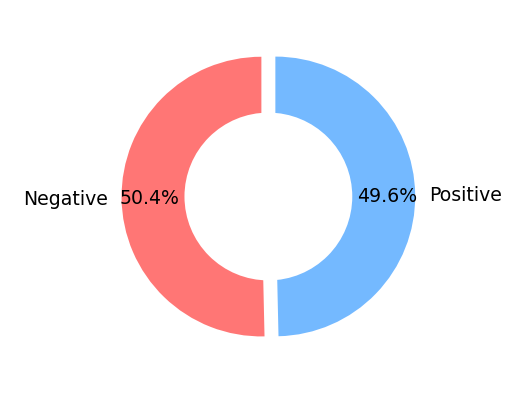

In [23]:
categoty_names = ['Negative', 'Positive']
sizes = [amount_of_negative_review, amount_of_positive_review]
custom_colours = ['#ff7675', '#74b9ff']
offset = [0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

#draw a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

### Word Cloud of Positive and Negative Reviews

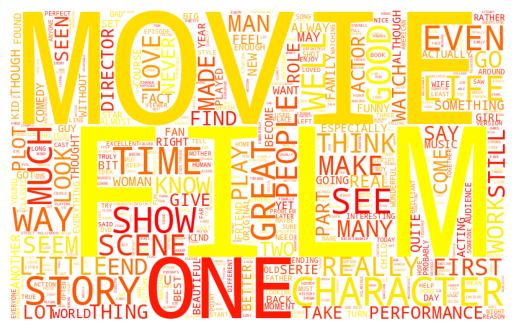

In [24]:
# Generate the text as a string for the Word Cloud
positive_str = ' '.join(list_positive)

wc = WordCloud(background_color='white', max_words=1000, colormap='autumn', width=800, height=500)
wc.generate(positive_str.upper())
plt.axis("off")
plt.imshow(wc)

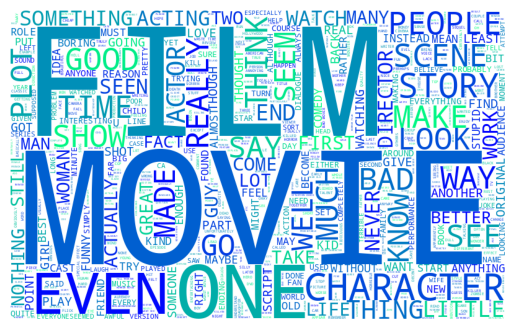

In [25]:
# Generate the text as a string for the Word Cloud
negative_str = ' '.join(list_negative)

wc = WordCloud(background_color='white', max_words=1000, colormap='winter', width=800, height=500)
wc.generate(negative_str.upper())
plt.axis("off")
plt.imshow(wc)

# Step 5: Model Preparation

In [26]:
max_length = max(len(sublist) for sublist in nested_list)
print(max_length)

6300


In [27]:
df.reset_index()
df.head()

,review,sentiment,category
35172,good acting cutting directing may best ever da...,positive,1
45440,wonderful movie eligible many label never get ...,positive,1
29623,song keep humming head greatest song movie lea...,negative,0
44446,female executioner played sexy jennifer thomas...,positive,1
21092,watched movie last night already struggling re...,negative,0


In [28]:
data_dict = {
    "Preprocessed Review": df['review'],
    "Target": df['category']
}

df_prep = pd.DataFrame(data_dict)
df_prep.head()

,Preprocessed Review,Target
35172,good acting cutting directing may best ever da...,1
45440,wonderful movie eligible many label never get ...,1
29623,song keep humming head greatest song movie lea...,0
44446,female executioner played sexy jennifer thomas...,1
21092,watched movie last night already struggling re...,0


In [29]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_prep['Preprocessed Review']).toarray()
y = np.array(df_prep['Target'].values, dtype='float64')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(11968, 2993, 11968, 2993)

In [31]:
LABELS = ['0', '1']

In [32]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots a confusion matrix using the true and predicted labels.

    Args:
        y_true (array-like): The true labels.
        y_pred (array-like): The predicted labels.
        labels (array-like): The list of labels to index the matrix.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Step 4: Model Training & Evaluation

## Logistic Regression

In [33]:
logreg = LogisticRegression(random_state=42, solver="saga")

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

accuracy_score(y_test, y_pred_lr)

0.8730370865352489

In [34]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87      1504
         1.0       0.86      0.89      0.87      1489

    accuracy                           0.87      2993
   macro avg       0.87      0.87      0.87      2993
weighted avg       0.87      0.87      0.87      2993



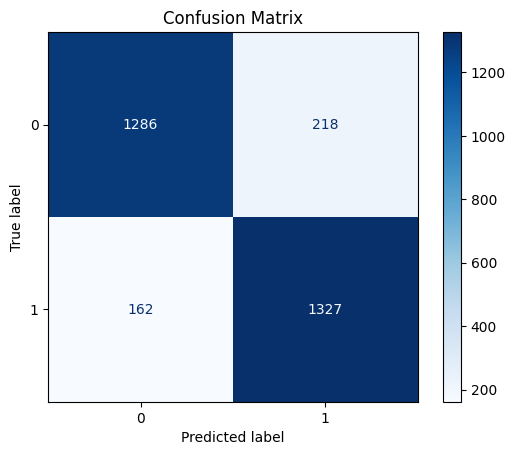

In [35]:
plot_confusion_matrix(y_test, y_pred_lr, LABELS)

## Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_dt = model.predict(X_test)

accuracy_score(y_test, y_pred_dt)

0.7029736050785166

In [37]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70      1504
         1.0       0.70      0.70      0.70      1489

    accuracy                           0.70      2993
   macro avg       0.70      0.70      0.70      2993
weighted avg       0.70      0.70      0.70      2993



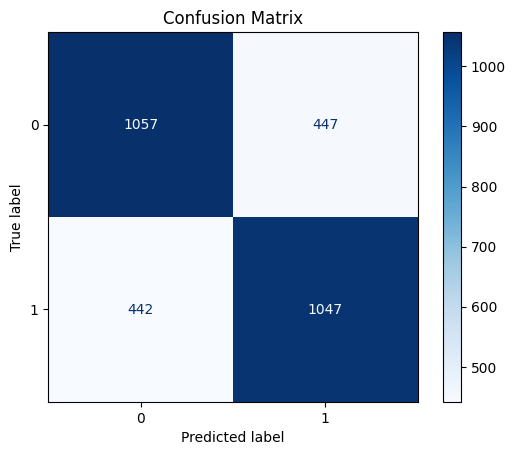

In [38]:
plot_confusion_matrix(y_test, y_pred_dt, LABELS)

## Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)

accuracy_score(y_test, y_pred_rf)

0.8379552288673572

In [40]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84      1504
         1.0       0.84      0.83      0.84      1489

    accuracy                           0.84      2993
   macro avg       0.84      0.84      0.84      2993
weighted avg       0.84      0.84      0.84      2993



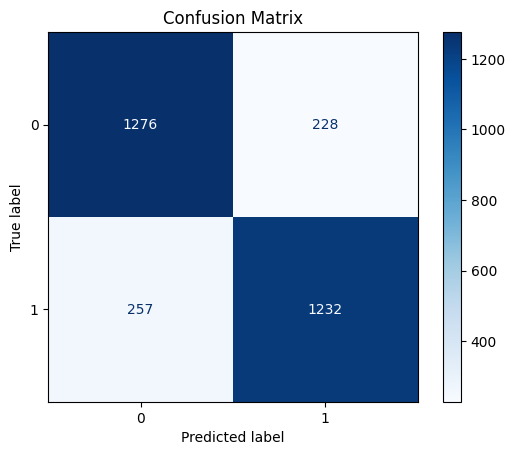

In [41]:
plot_confusion_matrix(y_test, y_pred_rf, LABELS)